This notebook reads one (or more) OTEANN results file(s) and vizualises them

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import codecs

def get_unique_chars(filename):
    unique_chars = set(char for line in codecs.open(filename, encoding="UTF-8") for char in line)
    return unique_chars

def display_orthography_letters(config):

    languages = config['languages']

    for lang in languages:
        filename = config['root_dir'] + '/' + config['subdatasets_dir'] + '/' + lang + '_' + config['subdataset']
        filename_g = filename + '_graphemes.tmp'
        filename_p = filename + '_phonemes.tmp'

        df = pd.read_csv(filename)

        df.Word.to_csv(filename_g, index=False, header=None)
        df_g = pd.read_csv(filename_g)

        df.Pronunciation.to_csv(filename_p, index=False, header=None)
        df_p = pd.read_csv(filename_p)

        unique_graphemes = get_unique_chars(filename_g)
        unique_phonemes = get_unique_chars(filename_p)
        
        os.remove(filename_g)
        os.remove(filename_p)
        print('%s, n_phonemes:%d, n_graphemes:%d' % (
            lang, len(unique_phonemes)-1, len(unique_graphemes)-1)) # -1 is for ''\n'
        print("graphemes:", sorted(unique_graphemes))
        print("phonemes:", sorted(unique_phonemes))
        print("-------------------------------")
#display_orthography_letters(config)

In [3]:
# These first configuration parameters are hyperparameters that we will need to tune
CONFIG = {            
    'n_train': 0,
}

ROOT_DIR = os.getcwd()

# These other configuration parameters will not be tuned
def extend_config(config): 
    config['languages'] = ['ent', 'eno','ar', 'br', 'de', 'en', 'es', 'fi', 'fr', 'fro', 'it', 'ko', 'nl', 'pt', 'ru', 'sh', 'tr']
    config['tasks'] = ['write', 'read']
    #config['languages'] = ['ent', 'eno', 'br', 'fr']
    #config['languages'] = ['ent']    
    config['n_test'] = 1000
    config['n_samples'] = config['n_train'] + config['n_test']
    config['label'] = 'oteann' + '_' + str(config['n_samples'])
    config['subdatasets_dir'] = 'subdatasets'
    config['subdataset'] = 'wikt_samples.csv' # postfix from fonetik.fr 
    config['root_dir'] = os.getcwd()    
    config['trial_dir'] = os.getcwd() 
    config['trial_filename'] = config['trial_dir'] + '/' + config['label']
    config['results_filename'] = config['trial_filename'] + '_results.csv'
    return config
        
config = extend_config(CONFIG)

In [4]:
def display_textual_results(config):
    df_results = pd.read_csv(config['results_filename']) 
    # display the "write" results of the different languages
    # the best writing-system is on the first line
    # the worst writing-system is on the last line
    print('scoring of the orthograpies with respect to "write" task:')
    print(df_results[df_results.task == 'write'].sort_values('test_accuracy', ascending=False))
    print()
    # display the "read" results of the different languages
    # the best reading-system is on the first line
    # the worst reading-system is on the last line
    print('scoring of the orthograpies with respect to "read" task:')
    print(df_results[df_results.task == 'read'].sort_values('test_accuracy', ascending=False))

In [5]:
def display_text_results(config):
    df_results = pd.read_csv(config['results_filename']) 
    # display the "write" results oe the different languages
    print("|-----------|------------|------------|")
    print("|orthography| write score| read score |")
    print("|-----------|------------|------------|")
    for lang in df_results.lang.unique():
        dfl = df_results[df_results.lang == lang]
        print("|    %3s    | %04.1f ± %2.1f | %04.1f ± %2.1f |" % (
              lang.ljust(3),
              round(dfl[dfl.task == 'write'].mean()*100, 1),
              round(dfl[dfl.task == 'write'].std()*100, 1),
              round(dfl[dfl.task == 'read'].mean()*100, 1),
              round(dfl[dfl.task == 'read'].std()*100, 1))
             )
        if lang == 'eno':
            print("|-----------|------------|------------|")
    print("|-----------|------------|------------|")

In [6]:
def display_latex_results(config):

    print('\\begin{figure}[h]')
    print('\centering')
    print('\captionsetup{justification=centering}')
    print('\\begin{floatrow}')
    print('\\capbtabbox{%')
    print('\\begin{tabular}{c c c}')
    print('\\hline')
    print('\\textbf{Language} & \\textbf{Write} & \\textbf{Read}\\\\')
    print('\\hline\hline')
    
    df_results = pd.read_csv(config['results_filename']) 
    # display the "write" results oe the different languages
    n = config['n_train']
    
    for lang in df_results.lang.unique():
        dfl = df_results[df_results.lang == lang]
        print("%s & %4.1f ± %2.1f & %4.1f ± %2.1f \\\\\\hline" % (
              lang.ljust(3),
              round(dfl[dfl.task == 'write'].mean()*100, 1),
              round(dfl[dfl.task == 'write'].std()*100, 1),
              round(dfl[dfl.task == 'read'].mean()*100, 1),
              round(dfl[dfl.task == 'read'].std()*100, 1))
             )
        if lang == 'eno':
            print('\\hline')  
    print('\\end{tabular}')
    print('}{%')
    print('  \\caption{Phonemic transparency scores. \\newline ' + 
          '(OTEANN trained with $' + f'{n:,}' + '$ samples)}%')
    print('  \\label{tab:tabular_results_' + str(config['n_samples']) + '}')
    print('}')
    print('\\ffigbox{%')
    print('\\includegraphics[width=7.5cm]{oteann_' + 
          str(config['n_samples']) + '_results.png}%')
    print('}{%')
    print('  \\caption{Scatterplot of the mean scores. \\newline ' + 
          '(OTEANN trained with $' + f'{n:,}' + '$ samples)}%')
    print('  \\label{fig:figure_results_' + str(config['n_samples']) + '}')
    print('}')
    print('\\end{floatrow}')
    print('\\end{figure}')

In [7]:
def display_barplot_results(config):
    
    df = pd.read_csv(config['results_filename'])
    
    sns.set(style="whitegrid")
    current_palette = sns.color_palette()
    for task in config['tasks']:
        df_o = df[df.task==task].sort_values(by='lang')
        df_o = df_o[['task', 'lang', 'test_accuracy']]
        df_o['test_accuracy']=df_o['test_accuracy']*100
        df_o = round(df_o.groupby('lang', as_index=False).mean())
        sns.palplot(current_palette)
        ax = sns.barplot(x="lang", y="test_accuracy",
                         data=df_o, palette=current_palette)
        # add the accuracy number on the top of each bar
        i=0
        for index, row in df_o.iterrows():
            ax.text(i, row.test_accuracy+1, str(round(row.test_accuracy)), color='black', ha="center")
            i+=1
        plt.title(task.capitalize())
        plt.ylim(0, 100)
        plt.show()

In [8]:
def display_boxplot_results(config):
    
    df = pd.read_csv(config['results_filename'])
    
    sns.set(style="whitegrid")
    current_palette = sns.color_palette()
    for task in config['tasks']:
        df_o = df[df.task==task].sort_values(by='lang')
        df_o = df_o[['task', 'lang', 'test_accuracy']]
        df_o['test_accuracy']=df_o['test_accuracy']*100
        #df_o = df_o.groupby('lang', as_index=False).mean()
        sns.palplot(current_palette)
        ax = sns.boxplot(x="lang", y="test_accuracy",
                         data=df_o, palette=current_palette)
        # add the accuracy number on the top of each bar
        i=0
        for index, row in df_o.iterrows():
            #ax.text(i, row.test_accuracy+1, str(round(row.test_accuracy)), color='black', ha="center")
            i+=1
        plt.title(task.capitalize())
        plt.ylim(0, 100)
        plt.show()

In [9]:
def display_config(config):
    n = config['n_train']
    print('n_train:', f'{n:,}')
    df_results = pd.read_csv(config['results_filename'])
    n_tasks = len(df_results['task'].unique())
    n_langs = len(df_results['lang'].unique())
    print('result file:')
    print('* n_tasks: %d' % n_tasks)
    print('* n_langs: %d' % n_langs)
    print('* n_rows: %d' % df_results.shape[0])
    if n_tasks > 0 and n_langs > 0:
        nb_episodes = float(df_results.shape[0]) / (n_tasks * n_langs)
        print('* nb_episodes: %.2f' % nb_episodes)

In [10]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+2, point['y'], str(point['val']))

def display_scatterplot_results(config):
    
    df_results = pd.read_csv(config['results_filename']) 
    
    df_results = df_results.groupby(['lang','task'], as_index=False).mean()
    
    df_w = df_results[df_results.task=='write']
    df_w.rename(columns={"task": "write"})
    df_r = df_results[df_results.task=='read']
    df_r.rename(columns={"task": "read"})

    df_res = df_w.merge(df_r, left_on='lang', right_on='lang')
    df_res = df_res.rename(columns={"test_accuracy_x": "write_accuracy", "test_accuracy_y": "read_accuracy"})
    df_res['write_accuracy'] = df_res['write_accuracy'] * 100
    df_res['read_accuracy'] = df_res['read_accuracy'] * 100

    ax = sns.lmplot(
        data=df_res, # Data source
        x= 'write_accuracy',
        y='read_accuracy',
        fit_reg=False, # Don't fix a regression line
        height = 5,
        aspect = 1 ) # size and dimension
    
    #plt.title('Transparency of the orthographies (with %d training samples)' % config['n_train'])
    # Set x-axis label
    plt.xlabel('Write transparency')
    # Set y-axis label
    plt.ylabel('Read transparency')
    
    label_point(df_res.write_accuracy, df_res.read_accuracy, df_res.lang, plt.gca())
    
    ax.set(xlim=(None, 101.5))
    ax.set(ylim=(None, 101.5))
    
    plt.subplots_adjust(left=-0.1, bottom=-0.1, right=1.05, top=1.05)
    plt.tight_layout()
    figure_file = 'oteann_' + str(config['n_samples']) + '_results.png'
    plt.savefig(figure_file)

In [11]:
def display_single_scatterplot_results(config, n_trains):
    
    sns.set(rc={'figure.figsize':(6.5, 6.5)})
    
    df_res = pd.DataFrame(columns=['n_train', 'lang', 'write_accuracy', 'read_accuracy'])
    for n_train in n_trains:
        config['n_train'] = n_train
        config = extend_config(config)
        df_results = pd.read_csv(config['results_filename']) 

        df_results = df_results.groupby(['lang','task'], as_index=False).mean()

        df_w = df_results[df_results.task=='write']
        df_w.rename(columns={"task": "write"})
        df_r = df_results[df_results.task=='read']
        df_r.rename(columns={"task": "read"})

        df_res_i = df_w.merge(df_r, left_on='lang', right_on='lang')
        df_res_i = df_res_i.rename(columns={"test_accuracy_x": "write_accuracy", "test_accuracy_y": "read_accuracy"})
        df_res_i = df_res_i.drop(columns=['task_x', 'task_y'])
        df_res_i['n_train'] = n_train

        df_res = df_res.append(df_res_i)
        
    ax = sns.scatterplot(
        data=df_res, # Data source
        x='write_accuracy',
        y='read_accuracy',
        hue='lang',
        size='n_train',
        alpha=0.40,
        #size_order=[1000, 2000, 10000, 12500]
    )

    #plt.title('Transparency of the orthographies (with %d training samples)' % config['n_train'])
    # Set x-axis label
    plt.xlabel('Write transparency')
    # Set y-axis label
    plt.ylabel('Read transparency')

    #df_res_last = df_res[df_res.n_train == n_trains[-1]]
    #label_point(df_res_last.write_accuracy, df_res_last.read_accuracy, df_res_last.lang, plt.gca())

    ax.set(xlim=(None, 1.015))
    ax.set(ylim=(None, 1.015))
    #plt.figure(figsize=(24,10))
    plt.subplots_adjust(left=-0.1, bottom=-0.1, right=1.05, top=1.05)
    plt.tight_layout()
    figure_file = 'oteann_' + str(config['n_samples']) + '_results.png'
    plt.savefig(figure_file)

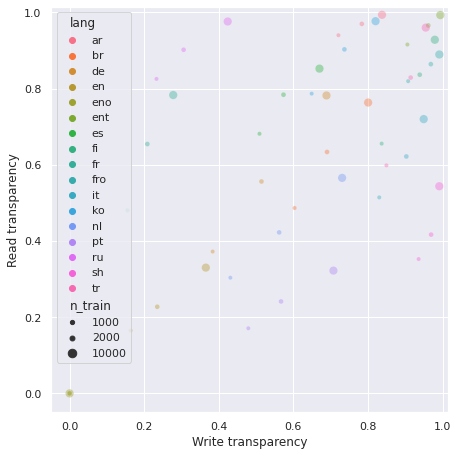

In [12]:
n_trains = [1000, 2000, 10000]

for n_train in n_trains:
    config['n_train'] = n_train
    config = extend_config(config)
display_single_scatterplot_results(config, n_trains)

########################################"
n_train: 1,000
result file:
* n_tasks: 2
* n_langs: 17
* n_rows: 374
* nb_episodes: 11.00
|-----------|------------|------------|
|orthography| write score| read score |
|-----------|------------|------------|
|    ent    | 90.6 ± 1.2 | 91.6 ± 1.2 |
|    eno    | 00.0 ± 0.0 | 00.0 ± 0.0 |
|-----------|------------|------------|
|    ar     | 72.1 ± 1.2 | 94.0 ± 0.7 |
|    br     | 60.3 ± 1.8 | 48.7 ± 3.5 |
|    de     | 38.4 ± 1.7 | 37.2 ± 1.9 |
|    en     | 16.4 ± 1.7 | 16.5 ± 1.3 |
|    es     | 50.9 ± 1.8 | 68.1 ± 1.4 |
|    fi     | 83.7 ± 1.8 | 65.6 ± 1.7 |
|    fr     | 15.5 ± 1.0 | 48.1 ± 2.3 |
|    fro    | 90.8 ± 2.0 | 82.0 ± 1.6 |
|    it     | 83.0 ± 1.8 | 51.4 ± 1.3 |
|    ko     | 64.9 ± 1.6 | 78.7 ± 1.6 |
|    nl     | 43.1 ± 1.7 | 30.4 ± 2.7 |
|    pt     | 47.9 ± 1.2 | 17.1 ± 1.2 |
|    ru     | 23.3 ± 1.5 | 82.6 ± 1.8 |
|    sh     | 93.6 ± 1.0 | 35.3 ± 1.5 |
|    tr     | 84.9 ± 1.3 | 59.9 ± 4.8 |
|-----------|------------|--

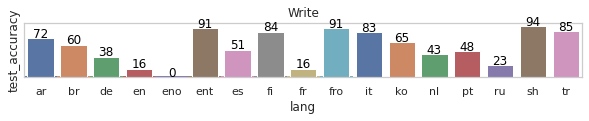

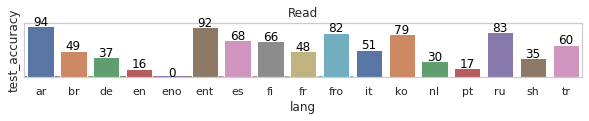

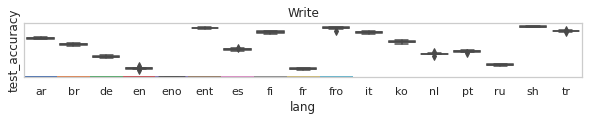

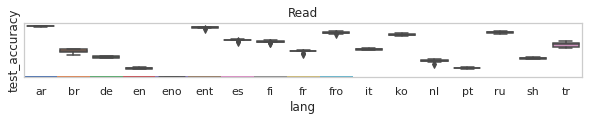

\begin{figure}[h]
\centering
\captionsetup{justification=centering}
\begin{floatrow}
\capbtabbox{%
\begin{tabular}{c c c}
\hline
\textbf{Language} & \textbf{Write} & \textbf{Read}\\
\hline\hline
ent & 90.6 ± 1.2 & 91.6 ± 1.2 \\\hline
eno &  0.0 ± 0.0 &  0.0 ± 0.0 \\\hline
\hline
ar  & 72.1 ± 1.2 & 94.0 ± 0.7 \\\hline
br  & 60.3 ± 1.8 & 48.7 ± 3.5 \\\hline
de  & 38.4 ± 1.7 & 37.2 ± 1.9 \\\hline
en  & 16.4 ± 1.7 & 16.5 ± 1.3 \\\hline
es  & 50.9 ± 1.8 & 68.1 ± 1.4 \\\hline
fi  & 83.7 ± 1.8 & 65.6 ± 1.7 \\\hline
fr  & 15.5 ± 1.0 & 48.1 ± 2.3 \\\hline
fro & 90.8 ± 2.0 & 82.0 ± 1.6 \\\hline
it  & 83.0 ± 1.8 & 51.4 ± 1.3 \\\hline
ko  & 64.9 ± 1.6 & 78.7 ± 1.6 \\\hline
nl  & 43.1 ± 1.7 & 30.4 ± 2.7 \\\hline
pt  & 47.9 ± 1.2 & 17.1 ± 1.2 \\\hline
ru  & 23.3 ± 1.5 & 82.6 ± 1.8 \\\hline
sh  & 93.6 ± 1.0 & 35.3 ± 1.5 \\\hline
tr  & 84.9 ± 1.3 & 59.9 ± 4.8 \\\hline
\end{tabular}
}{%
  \caption{Phonemic transparency scores. \newline (OTEANN trained with $1,000$ samples)}%
  \label{tab:tabular_result

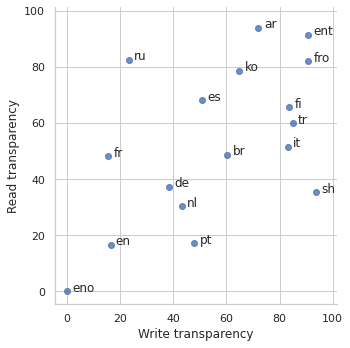

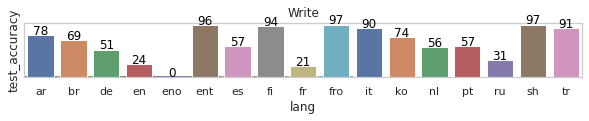

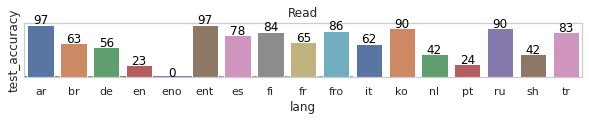

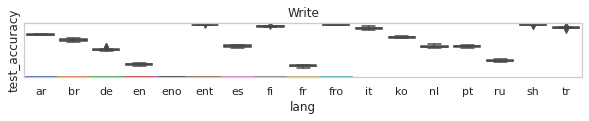

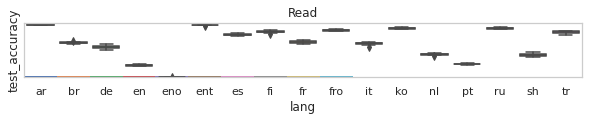

\begin{figure}[h]
\centering
\captionsetup{justification=centering}
\begin{floatrow}
\capbtabbox{%
\begin{tabular}{c c c}
\hline
\textbf{Language} & \textbf{Write} & \textbf{Read}\\
\hline\hline
ent & 96.2 ± 0.8 & 96.6 ± 0.7 \\\hline
eno &  0.0 ± 0.0 &  0.0 ± 0.0 \\\hline
\hline
ar  & 78.3 ± 1.2 & 97.0 ± 0.6 \\\hline
br  & 69.0 ± 2.1 & 63.4 ± 1.6 \\\hline
de  & 51.4 ± 2.2 & 55.6 ± 3.1 \\\hline
en  & 23.5 ± 1.7 & 22.7 ± 1.4 \\\hline
es  & 57.3 ± 1.8 & 78.4 ± 2.4 \\\hline
fi  & 93.9 ± 0.8 & 83.7 ± 2.0 \\\hline
fr  & 20.8 ± 1.7 & 65.5 ± 2.2 \\\hline
fro & 96.9 ± 0.9 & 86.4 ± 1.1 \\\hline
it  & 90.3 ± 1.8 & 62.2 ± 2.5 \\\hline
ko  & 73.7 ± 1.3 & 90.3 ± 1.3 \\\hline
nl  & 56.2 ± 2.2 & 42.3 ± 1.7 \\\hline
pt  & 56.7 ± 2.0 & 24.1 ± 0.9 \\\hline
ru  & 30.6 ± 1.4 & 90.2 ± 1.1 \\\hline
sh  & 96.9 ± 0.5 & 41.7 ± 2.8 \\\hline
tr  & 91.4 ± 1.5 & 82.9 ± 2.2 \\\hline
\end{tabular}
}{%
  \caption{Phonemic transparency scores. \newline (OTEANN trained with $2,000$ samples)}%
  \label{tab:tabular_result

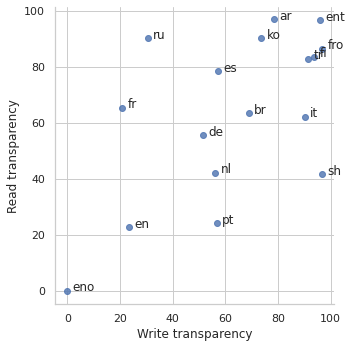

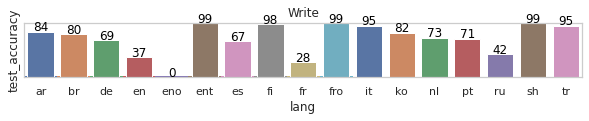

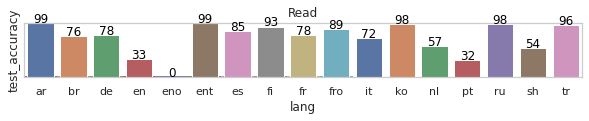

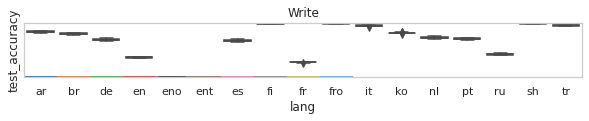

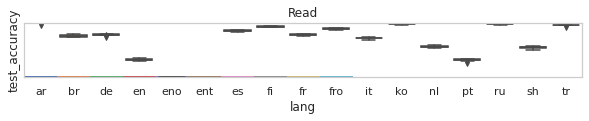

\begin{figure}[h]
\centering
\captionsetup{justification=centering}
\begin{floatrow}
\capbtabbox{%
\begin{tabular}{c c c}
\hline
\textbf{Language} & \textbf{Write} & \textbf{Read}\\
\hline\hline
ent & 99.4 ± 0.2 & 99.3 ± 0.3 \\\hline
eno &  0.0 ± 0.0 &  0.0 ± 0.0 \\\hline
\hline
ar  & 83.8 ± 1.3 & 99.4 ± 0.3 \\\hline
br  & 80.0 ± 1.1 & 76.3 ± 1.7 \\\hline
de  & 68.9 ± 1.4 & 78.2 ± 1.0 \\\hline
en  & 36.5 ± 0.6 & 33.0 ± 1.8 \\\hline
es  & 67.0 ± 1.3 & 85.2 ± 1.2 \\\hline
fi  & 97.9 ± 0.4 & 92.8 ± 0.8 \\\hline
fr  & 27.8 ± 0.9 & 78.3 ± 1.2 \\\hline
fro & 99.1 ± 0.3 & 89.0 ± 1.2 \\\hline
it  & 94.9 ± 0.8 & 72.0 ± 1.4 \\\hline
ko  & 82.0 ± 1.2 & 97.7 ± 0.5 \\\hline
nl  & 73.1 ± 1.8 & 56.6 ± 1.5 \\\hline
pt  & 70.7 ± 1.2 & 32.2 ± 1.8 \\\hline
ru  & 42.4 ± 1.7 & 97.6 ± 0.7 \\\hline
sh  & 99.1 ± 0.2 & 54.4 ± 2.3 \\\hline
tr  & 95.5 ± 0.7 & 96.0 ± 0.7 \\\hline
\end{tabular}
}{%
  \caption{Phonemic transparency scores. \newline (OTEANN trained with $10,000$ samples)}%
  \label{tab:tabular_resul

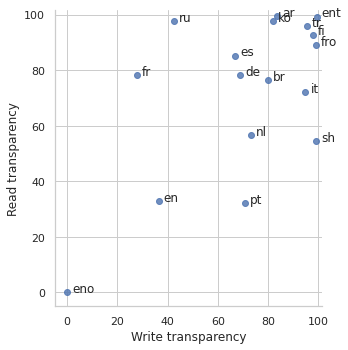

In [13]:
results = [1000, 2000, 10000]

for n_train in results:
    print('########################################"')
    config = { 
        'n_train': n_train
    }
    config = extend_config(config)
    #display_textual_results(config)
    display_config(config)
    display_text_results(config)
    display_barplot_results(config)
    display_boxplot_results(config)
    display_latex_results(config)
    display_scatterplot_results(config)
    print('########################################"')